In [280]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta
from scipy.optimize import brentq

<font size="6">
Berechnung des internen Zinsfuß eines Immobilieninvestments

Ausgangsfrage: 
Lohnt sich ein Immobilieninvestition mit Annuitätendarlehen unter Rendite-Askpeten?

Strategie: 
1) Aufstellen sämtlicher Cashflows entlang der Investition, dann Berechnung des internen Zinsfuß
2) Vergleich mit Benchmark: Die gleichen Cashflows in MSCI world (bei unterschiedlichen Startdaten)






Parameter Immobilie (fix):
1) Kaufpreis in €
2) Nebenkosten in €
3) Grundstückswert in €
4) Kaltmiete in € pro Monat
5) Hausgeld in € pro Monat
6) Anteil nicht umlegbarer Hausgeldkosten (Hausgeldfaktor)
7) Abschreibung der Wohnung (Immobilienwert ausschließlich Grundstückswert) pro Jahr

Steuern (fix):
1) Einkommenssteuersatz (zur Versteuerung des Mieteinkommens abzüglich Kosten)

Parameter Finanzierung (flexibel):
1) Zinssatz
2) Tilgung 
3) Eigenkapital
4) Gesamtlaufzeit in Jahren (von Kauf bis Verkauf Immobilie; mindestens 10 Jahre, um Versteuerung bei Verkauf zu vermeiden)

Parameter (geschätzt):
1) Wertsteigerung pro Jahr
2) Leerstandsquote 
3) Instandhaltungskosten pro Jahr

In [321]:
#Eingabe von Parametern
para_fixed = {
    "Kaufpreis": 110000,
    "Nebenkosten": 8840,
    "Kaltmiete":400,
    "Grundstückswert":20000,
    "Hausgeld":190,
    "Hausgeldfaktor":0.226,
    "Abschreibung":0.02,
    "Steuersatz":0.42
}

para_flex={
    "Zinssatz":0.035,
    "Tilgung":0.01,
    "Eigenkapital":10000,
    "Laufzeit":10
}

para_estimate= {
    "Wertsteigerung":0.015,
    "Leerstand":0.05,
    "Instandhaltung":500
}


Rollout Cashflow

In [324]:
#Rollout Cashflows (jährlich)

def cashflow(para_fixed, para_flex, para_estimate):
    T=para_flex["Laufzeit"]
    year=list(range(T+1))
    
    Restschuld=np.zeros(T+1)
    Tilgung=np.zeros(T+1)
    Zins=np.zeros(T+1)

    #Ende Jahr 1 (besonders, da hier Annuität berechnet wird)
    Restschuld[0]=para_fixed["Kaufpreis"]+para_fixed["Nebenkosten"]-para_flex["Eigenkapital"]
    #Wir tilgen im ersten Jahr 2% der Restschuld
    Tilgung[1]=Restschuld[0]*para_flex["Tilgung"]
    #Außerdem fallen im ersten Jahr Zinsen auf das Darlehen an 
    Zins[1]=Restschuld[0]*para_flex["Zinssatz"]
    #Summe aus Tilgung und Zins ergibt Annuität
    Annuität=round(Tilgung[1]+Zins[1], 2)
    #Diese wird jedes Jahr bedient
    Annu_list=[Annuität]*(T+1)
    #(mit Ausnahme vom Ende von Jahr 0, dem Kaufzeitpunkt)
    Annu_list[0]=0

    #Berechne Restschuld in den nächsten Jahren: Erhöht sich durch Zins, verringert sich durch Annuität
    for k in np.arange(1, T+1):
        Restschuld[k]=round(Restschuld[k-1]*(1+para_flex["Zinssatz"])-Annuität, 2)

    #Berechne wieviel Zinsen und Tilgung im Jahr anfallen
    for k in np.arange(2, T+1):
        Zins[k]=round(para_flex["Zinssatz"]*Restschuld[k-1], 2)
        Tilgung[k]=Annuität-Zins[k]



    #Mieteinnahmen (abzüglich Leerstand, ohne Erhöhung. Nehme an, dass der Leerstand sich gleichmäßig auf alle Jahre verteilt)
    NettoEinnahmen=np.zeros(T+1)
    Mieteinnahmen=para_fixed["Kaltmiete"]*12*(1-para_estimate["Leerstand"])
    Miete_list=[Mieteinnahmen]*(T+1)
    #Am Ende von Jahr 0 gibt es keine Miete
    Miete_list[0]=0

    #Laufende Kosten: Hausgeld und Instandhaltung
    Hausgeldkosten=para_fixed["Hausgeldfaktor"]*para_fixed["Hausgeld"]*12
    Kosten_list=[Hausgeldkosten+para_estimate["Instandhaltung"]]*(T+1)
    Kosten_list
    Kosten_list[0]=0
    
    #Abschreibungsgrundlage: Kaufpreis inklusive Nebenkosten, exklusive Grundstückswert
    Ab_grundlage=para_fixed["Kaufpreis"]+para_fixed["Nebenkosten"]-para_fixed["Grundstückswert"]
    #Steuerlich abgeschrieben: Abschreibungsgrundlage mal Abschreibung
    Abschreibung=Ab_grundlage*para_fixed["Abschreibung"]
    

    #Berechnung Nettoeinnahmen für Steuern: Miete abzüglich Hausgeldkosten, Zinskosten, Abschreibung 
    NettoEinnahmen=np.zeros(T+1)
    for k in np.arange(1, T+1):
        NettoEinnahmen[k]=Mieteinnahmen-Hausgeldkosten-Zins[k]-Abschreibung
    #Berechnung Steuern auf steuerlich relevante Einnahmen
    Steuern=NettoEinnahmen*para_fixed["Steuersatz"]
    #Runde Steuern auf Centbeträge
    for k in np.arange(0, T+1):
        Steuern[k]=round(Steuern[k], 2)


    #Berechnung des Cashflow abzüglich Steuern
    CashFlow=np.zeros(T+1)
    for k in np.arange(1, T+1):
        CashFlow[k]=Mieteinnahmen-Steuern[k]-Hausgeldkosten-para_estimate["Instandhaltung"]-Annuität

    #Am Laufzeitende wird die Immobilie verkauft, es entsteht ein Gewinn
    Gewinn=round(para_fixed["Kaufpreis"]*(1+para_estimate["Wertsteigerung"])**T-Restschuld[-1], 2)

    CashFlow[-1]=CashFlow[-1]+Gewinn
    CashFlow[0]=(-1)*para_flex["Eigenkapital"]







    #Kosten sind Hausgeld+Instandhaltung

    df = pd.DataFrame({
        "Jahr": year,
        "Restschuld": Restschuld,
        "Zins": Zins,
        "Tilgung": Tilgung,
        "Annuität": Annu_list,
        "Miete": Miete_list,
        "Kosten": Kosten_list,
        "Steuern": Steuern,
        "Cashflow": CashFlow
    })
    return df

print(cashflow(para_fixed=para_fixed, para_flex=para_flex, para_estimate=para_estimate))




    Jahr  Restschuld     Zins  Tilgung  Annuität   Miete   Kosten  Steuern  \
0      0   108840.00     0.00     0.00       0.0     0.0     0.00     0.00   
1      1   107751.60  3809.40  1088.40    4897.8  4560.0  1015.28  -731.42   
2      2   106625.11  3771.31  1126.49    4897.8  4560.0  1015.28  -715.42   
3      3   105459.19  3731.88  1165.92    4897.8  4560.0  1015.28  -698.86   
4      4   104252.46  3691.07  1206.73    4897.8  4560.0  1015.28  -681.72   
5      5   103003.50  3648.84  1248.96    4897.8  4560.0  1015.28  -663.99   
6      6   101710.82  3605.12  1292.68    4897.8  4560.0  1015.28  -645.62   
7      7   100372.90  3559.88  1337.92    4897.8  4560.0  1015.28  -626.62   
8      8    98988.15  3513.05  1384.75    4897.8  4560.0  1015.28  -606.95   
9      9    97554.94  3464.59  1433.21    4897.8  4560.0  1015.28  -586.60   
10    10    96071.56  3414.42  1483.38    4897.8  4560.0  1015.28  -565.53   

    Cashflow  
0  -10000.00  
1    -621.66  
2    -637.66  
3  

Berechnung des internen Zinsfuß entlang Cashflow

In [327]:
#Berechne internen Zinsfuß des Cashflows

def IRR(coeff):
    p = np.poly1d(coeff)
    root = brentq(p, 1, 1.5)
    return round((root-1)*100, 2)

coeff=cashflow(para_fixed, para_flex, para_estimate)["Cashflow"].tolist()
print(f'Interner Zinsfuß ist {IRR(coeff)}%')


Interner Zinsfuß ist 8.01%


<font size="6">
Berechnung interner Zinsfuß von MSCI investment bei gleichen Cashflows

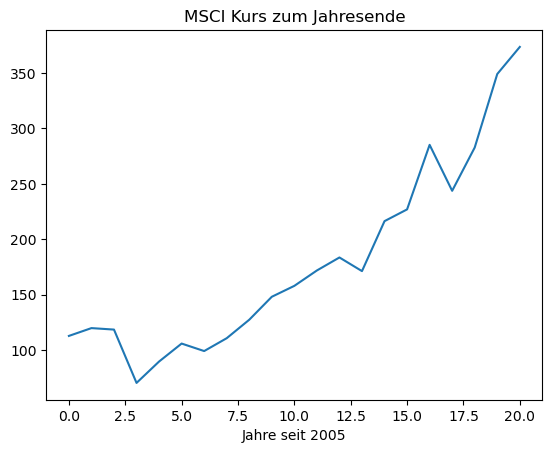

In [330]:
#Daten MSCI world index am Ende eines jeden Jahrs, beginnend 2005

df=pd.read_csv("msci.csv",  skiprows=2, names=["Date", "MSCI AC World Index"], sep=";", decimal=",")
df.columns = ["Date", "MSCI AC World Index"]
df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y %H:%M:%S')
df.set_index('Date', inplace=True)
year_last = df['MSCI AC World Index'].resample('YE').last().tolist()

plt.plot(year_last)
plt.title('MSCI Kurs zum Jahresende')
plt.xlabel('Jahre seit 2005')
plt.show()

Berechne IRR entlang Cashflow mit gegebenen Stardatum. Dann erstelle Liste, in der diese IRR aufgeführt sind, in Abhängigkeit des Startzeitpunkts.

In [333]:
def IRR_msci(start, coeff):
    #importiere cashflows
    
    T=len(coeff)   
    #berechne wieviele Anteile entlang des Cashflows gekauft werden können
    stock_units=np.zeros(T)
    for k in range(T):
        stock_units[k]=(-1)*coeff[k]/year_last[start+k]

    #Zum Schluss, verkaufe alle Anteile (abzüglich 25% Kapitalertragssteuer)

    #Wieviele Anteile werden gehalten
    total_stocks=sum(stock_units[:(-1)])
    #Was sind diese wert
    final_position=total_stocks*year_last[start+T]
    #Abzug steuern
    invested_capital=(-1)*sum(coeff[:-1])
    steuern=(final_position-invested_capital)*0.25
    final_gain=final_position-steuern
    
    

    cashflow_new=coeff
    cashflow_new[-1]=final_gain

    return IRR(cashflow_new)


def IRR_msci_list(coeff):
    t=len(year_last)
    irr=np.zeros(t-len(coeff))
    for k in range(t-len(coeff)):
        irr[k]=IRR_msci(k, coeff)
    return irr

Plot results

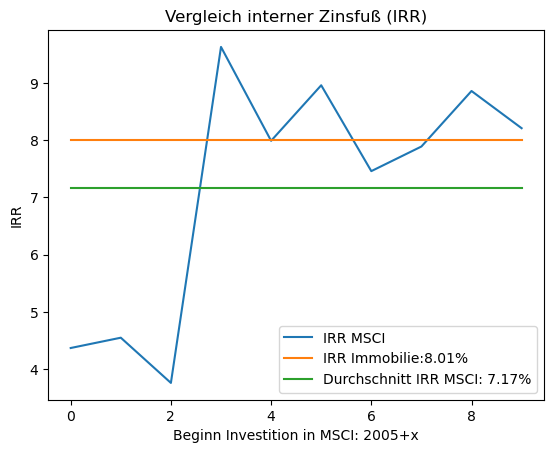

In [336]:
coeffi=cashflow(para_fixed, para_flex, para_estimate)["Cashflow"].tolist()



immo=[IRR(coeffi)]*(len(year_last)-len(coeffi))
av_msci=[np.mean(IRR_msci_list(coeff))]*(len(year_last)-len(coeffi))
plt.plot(IRR_msci_list(coeff=coeff), label='IRR MSCI')
plt.plot(immo, label=f'IRR Immobilie:{IRR(coeffi)}%')
plt.plot(av_msci, label=f'Durchschnitt IRR MSCI: {round(np.mean(IRR_msci_list(coeff)), 2)}%')
plt.ylabel('IRR')
plt.legend()
plt.xlabel('Beginn Investition in MSCI: 2005+x')
plt.title('Vergleich interner Zinsfuß (IRR)')
plt.show()
